In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

### Question 1
Create a clean data set where each column is a field in the URL, each row is a given search and the cells are the corresponding URL values.

In [2]:
len('http://www.mysearchforhotels.com/shop/hotelsearch?')

50

In [3]:
with open('C:/Sophia/School!!!/2023 Spring 1/DS take home/16.Hotel_Search/url_list.txt') as f:
    lines = f.readlines()
    
print('Total Records:\t', len(lines))

Total Records:	 77677


In [4]:
def parse_search(lines):
    """ function to parse user's search history """
    length = len(lines)
    names = ['checkin', 'checkout', 'customMinimumPriceFilter', 
             'customMaximumPriceFilter', 'freeCancellation', 'stars_5', 
             'stars_4', 'stars_3', 'stars_2', 'stars_1', 'max_score', 
             'min_score', 'couponCode', 'adults', 'city', 'children', 
             'amenities', 'search_page']
    
    maps = {}
    for name in names:
        maps[name] = [np.nan] * length
      
    for i in range(length):
        line = lines[i]
        items = line[50:].strip().split('&')
        visited = set()
        for item in items:
            key, value = item.strip().split('=')
            key = key.strip().split('.')[1]
            if key == 'city':
                value = value.strip().replace('+', ' ')
            if key not in visited:
                maps[key][i] = value
                visited.add(key)
            else:
                maps[key][i] = maps[key][i] + ', ' + value
            
    # transform into DataFrame
    df = pd.DataFrame(maps, columns=names)
    df['checkin'] = pd.to_datetime(df['checkin'])
    df['checkout'] = pd.to_datetime(df['checkout'])
    df = df.rename(columns={'customMinimumPriceFilter': 'MinPrice', 
                            'customMaximumPriceFilter': 'MaxPrice'})
    
    return df

In [5]:
# parse all the data
data = parse_search(lines)
data.head()

,checkin,checkout,MinPrice,MaxPrice,freeCancellation,stars_5,stars_4,stars_3,stars_2,stars_1,max_score,min_score,couponCode,adults,city,children,amenities,search_page
0,2015-09-19,2015-09-20,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,NaN,4,NaN,3,"New York, NY, United States",NaN,NaN,1
1,2015-09-14,2015-09-15,NaN,NaN,NaN,NaN,NaN,yes,NaN,NaN,NaN,4,NaN,3,"London, United Kingdom",NaN,NaN,1
2,2015-09-26,2015-09-27,NaN,175,NaN,NaN,yes,NaN,NaN,NaN,NaN,5,NaN,2,"New York, NY, United States",NaN,NaN,1
3,2015-09-02,2015-09-03,NaN,NaN,NaN,yes,yes,NaN,NaN,NaN,NaN,4,NaN,1,"Hong Kong, Hong Kong",NaN,NaN,1
4,2015-09-20,2015-09-29,NaN,275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,3,"London, United Kingdom",NaN,NaN,1


In [6]:
# check basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77677 entries, 0 to 77676
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   checkin           77677 non-null  datetime64[ns]
 1   checkout          77677 non-null  datetime64[ns]
 2   MinPrice          1270 non-null   object        
 3   MaxPrice          49288 non-null  object        
 4   freeCancellation  17949 non-null  object        
 5   stars_5           4303 non-null   object        
 6   stars_4           12704 non-null  object        
 7   stars_3           14862 non-null  object        
 8   stars_2           9931 non-null   object        
 9   stars_1           9323 non-null   object        
 10  max_score         5517 non-null   object        
 11  min_score         60826 non-null  object        
 12  couponCode        2221 non-null   object        
 13  adults            77677 non-null  object        
 14  city              7767

In [7]:
# check missing values
missing = data.isnull().sum().reset_index()
missing = missing.rename(columns={'index': 'name', 0: 'missing'})
missing['ratio'] = missing['missing'] / len(data)
missing[missing['missing'] > 0]

,name,missing,ratio
2,MinPrice,76407,0.983650
3,MaxPrice,28389,0.365475
4,freeCancellation,59728,0.768928
5,stars_5,73374,0.944604
6,stars_4,64973,0.836451
7,stars_3,62815,0.808669
8,stars_2,67746,0.872150
9,stars_1,68354,0.879977
10,max_score,72160,0.928975
11,min_score,16851,0.216937


### Question 2
For each search query, how many amenities were selected?

In [8]:
# value counts
data['amenities'].value_counts()

internet                272
yes_smoking             170
shuttle                 111
yes_pet                  85
breakfast                39
lounge                   22
yes_smoking, yes_pet      4
breakfast, yes_pet        1
Name: amenities, dtype: int64

In [9]:
# check number of 
data['amenities_count'] = data['amenities'].apply(lambda x: 0 if pd.isnull(x) 
                                                  else len(x.split(', ')))
data['amenities_count'].value_counts()

0    76973
1      699
2        5
Name: amenities_count, dtype: int64

### Question 3
Often, to measure the quality of a search algorithm, data scientists use some metric based on how often users click on the second page, third page, and so on. The idea here is that a great search algorithm should return all interesting results on the first page and never force users to visit the other pages (how often do you click on the second page results when you search on Google? Almost never, right?). 
- Create a metric based on the above idea and find the city with the worst search algorithm.

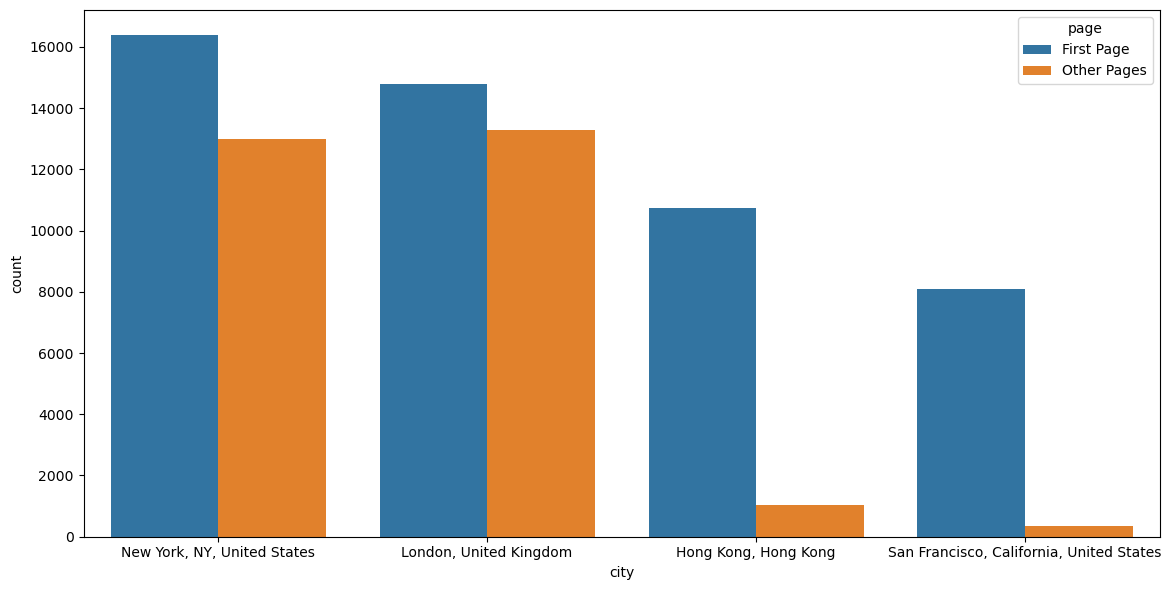

In [10]:
data['page'] = data['search_page'].apply(lambda x: 'First Page' if x == '1' else 'Other Pages')

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x='city', hue='page', data=data, ax=ax)
plt.tight_layout()
plt.show()

In [11]:
grouped = data.groupby(['city', 'page'])['checkin'].count().unstack()
grouped['ratio'] = grouped['Other Pages'] / (grouped['First Page'] + grouped['Other Pages'])

grouped

page,First Page,Other Pages,ratio
city,,,
"Hong Kong, Hong Kong",10735,1051,0.089174
"London, United Kingdom",14775,13283,0.473412
"New York, NY, United States",16385,12999,0.442384
"San Francisco, California, United States",8105,344,0.040715


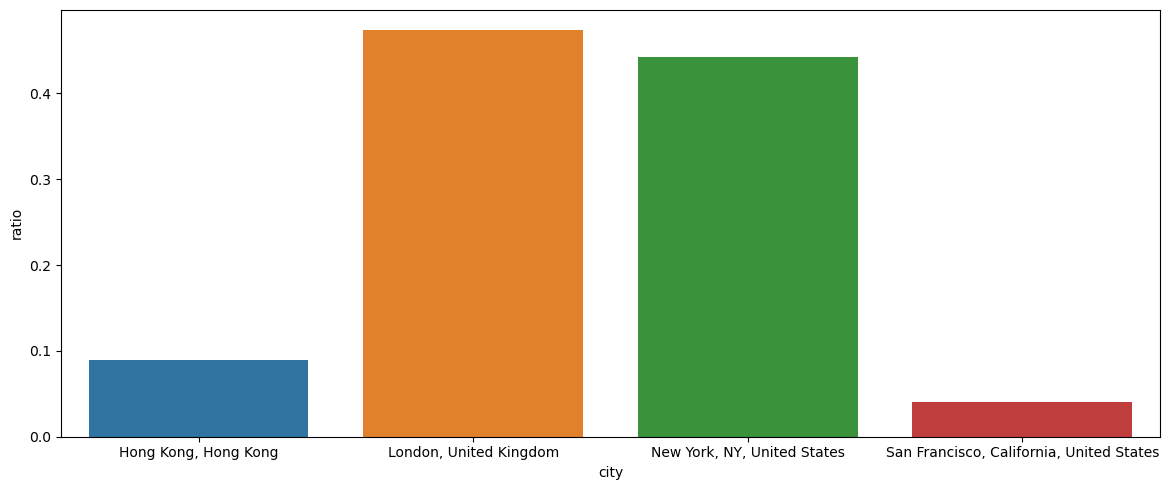

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.barplot(x=grouped.index, y='ratio', data=grouped, ax=ax)
plt.tight_layout()
plt.show()

If we use the ratio of other pages versus total visits, we can see that London and New York have pretty high ratio. It's clear that London and New York have pretty bad search algorithms.